# Solar Output Prediction 
### Writeup + Technical Analysis

by Evan Baker

### Table of Contents

1. [Introduction](#Introduction)
2. [Executive Summary](#summary)
3. [Gathering Data](#data)
4. [Gathering Radiation Data](#solar-data)    
5. [Data Cleaning](#cleaning)
6. [Exploratory Analysis](#eda)
7. [Outliers](#outliers)
8. [Modeling Energy Output](#energy-model)
9. [Feature Engineering](#feature-engineering)
10. [Baseline Score](#baseline)
11. [Linear Regression Model](#linear-regression)
12. [Elastic Net Model](#elastic-net)
13. [Random Forest Model](#random-forest)
14. [Neural Network Model](#neural-net)  
15. [Modeling Energy Output/Size](#output-size)
16. [Modeling Installation Cost](#cost-model)

For a non-technical writeup on this project, head over to my <a href=https://medium.com/@evanbaker/predicting-solar-energy-production-with-machine-learning-19fcab295e58>article on Medium</a>

<a id='Introduction'></a>
## Introduction

Over the past 10 years, installation costs for solar energy technology have dropped an astonishing 60%¹. This form of renewable energy is more accessible now than ever before. Yet over that same period, soft costs, such as sales and marketing, have remained almost completely stagnant. According to the Solar Energy Industries Association (SEIA), in Q4 2016, soft costs accounted for 67% of installation costs for residential solar². This has moved the impetus for growth in the solar industry from the development of cheaper technologies to a focus on ways to attack soft costs by more efficiently spreading information to potential solar customers.

<img src="http://www.seia.org/sites/default/files/Fig4-SolarPVPriceBreakdown-2017YIR.png" style="width:700px;height:400px;">

## Executive Summary

My goal with this project is to build a tool that makes information regarding one’s potential for switching to solar available to a wider audience, bringing down the cost of sales and marketing. I accomplished this goal in three stages:
1. Building a machine learning model that predicts the annual energy production of a prospective solar installation.
2. Building a model that predicts installation cost.
3. Implementing these models on a user-friendly web app that shows users how much they should expect to save on their energy bill each year by switching to solar.

The final web app is up and running, and is available <a href=www.solarcalculator.xyz>here</a>. Using a random forest model, I was able to predict expected annual savings to around +/- $15.00, a 75% increase in accuracy over predictions generated by the National Renewable Energy Laboratory (NREL).

<img src="https://cdn-images-1.medium.com/max/600/1*3eBpIxun72lFGzCGykH7yQ.png" style="width:700px;height:400px;">

### Data

Data for this project came from two sources, both managed by the NREL. The first is The OpenPV Project, which contains data related to over one million solar panel installations across the U.S. This dataset includes the following:
Annual energy production
- Installation cost
- Size
- Orientation
- Tilt
- Installer
- Technology type
- etc.

<img src=http://cspworld.org/sites/default/files/guide/nrel-logo.jpg>

The OpenPV data was simply downloaded in CSV format from the NREL website, located here: https://openpv.nrel.gov/search

### Solar Data

The second dataset comes from the National Solar Radiation Database (NSRDB) API. This dataset includes hourly measures of:
- Radiation
- Temperature
- Wind speed
- Position of the sun

The NSRDB API only allows one thousand daily queries, so in order to gather local radiation data for the roughly fifteen thousand ZIP codes in the OpenPV dataset, I wrote a python script, set it to run every twenty-four hours, and deployed it on a remote Amazon Web Services EC2 instance. The script pulled hourly data from all of 2015 (the most recent data available), averaged it for the year, and saved it to a local MySQL database. Once I had pulled down radiation data for all one million solar panel installations, I merged the two datasets according to ZIP code, the most granular location measure available.

Below is the script used to gather radiation data.


# Data Cleaning

Given that the OpenPV dataset is manually entered data with over one million rows, getting the most out of it required a lot of data cleaning and imputation.  For more on what processes I used, go to this notebook: https://github.com/iamlostcoast/capstone/blob/master/cleaning_open_pv_all.ipynb

# Exploratory Analysis

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
import pandas as pd
import numpy as np

In [7]:
# First let's read in the data.
df = pd.read_csv("./open_pv_clean.csv")
df.head()

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (14,16,17,24,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,level_0,index,state,date_installed,incentive_prog_names,type,size_kw,appraised,zipcode,install_type,...,tilt1,tracking_type,azimuth1,manufacturer,inv_man_clean,reported_annual_energy_prod,new_constr,tracking,3rdparty,bipv
0,0,0,TX,2013-12-12 00:00:00,Austin Energy,uir,10.560,0.0,78702.0,residential,...,10.0,Fixed,180.0,Chint Solar (Zhejiang),NaN,13836.0,0.0,0.0,0.0,0
1,1,1,TX,2014-07-11 00:00:00,Austin Energy,uir,12.720,0.0,78702.0,residential,...,7.0,Fixed,180.0,NaN,NaN,16419.0,0.0,0.0,0.0,0
2,2,2,TX,2014-01-17 00:00:00,Austin Energy,uir,5.400,0.0,78702.0,residential,...,18.5,Fixed,165.0,NaN,NaN,7235.0,0.0,0.0,0.0,0
3,3,3,IN,2017-10-06 00:00:00,no_incentive_program,uir,6.785,0.0,47403.0,residential,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0
4,4,4,IN,2017-10-06 00:00:00,no_incentive_program,uir,4.720,0.0,47408.0,residential,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0


In [9]:
# dropping unnecessary rows
del(df['city'])
del(df['manufacturer'])
del(df['inv_man_clean'])
del(df['model1_clean'])
del(df['sales_tax_cost'])
del(df['annual_insolation'])
del(df['lbnl_tts'])
del(df['county'])
del(df['date_installed'])
del(df['cost_per_watt'])


# imputing data for tilt and azimuth.  Picking the median to avoid biasing the model.
median_tilt = df.tilt1.median()
median_azimuth = df.azimuth1.median()

df.tilt1.fillna(median_tilt, inplace=True)
df.azimuth1.fillna(median_azimuth, inplace=True)

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (14,16,17,24,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


It's clear from the below graph that annual energy produced is extremely well correlated with the size of the installation.  This will be by far the most predictive feature in my models.

In [10]:
df = df.dropna()

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


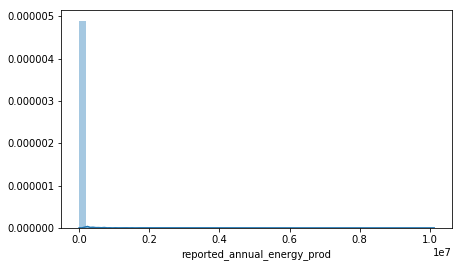

In [11]:
# Let's start out by looking at the distribution of our target variable (reported annual energy produced, 
# which will give us a better idea of what type of models will work well.


# It's clear that this skews really positive, and is clearly not normally distributed.
plt.figure(figsize=((7,4)))
sns.distplot(df.reported_annual_energy_prod)

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


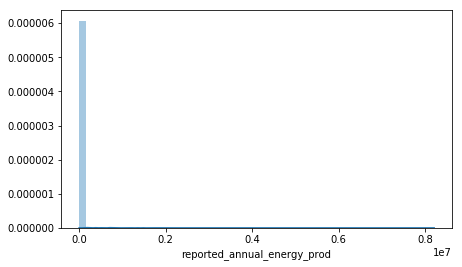

In [12]:
# We may seeing the skew from the utility scale installations, let's take those out and look at this distribution.

# Still skews really high when we only look at residential.
plt.figure(figsize=((7,4)))
sns.distplot(df.loc[df['install_type'] == 'residential'].reported_annual_energy_prod)

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


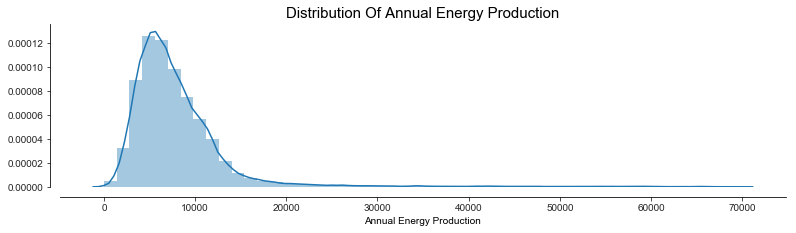

In [13]:
# let's just look at the lower values of annual energy output.

mask = df['reported_annual_energy_prod'] <= 70000
plt.figure(figsize=((13,3)))
sns.distplot(df[mask].reported_annual_energy_prod)
plt.title("Distribution Of Annual Energy Production", size=15)
plt.xlabel("Annual Energy Production")
sns.set_style("white")
sns.despine(offset=10, trim=False);

# We can see the skew a little more clearly when we limit the energy production to below 60000 kilowatt hours annually.

# Given this distribution, we may want to do a log transformation of the target, or use a generalized linear model
# like a poisson regression.

### Log Transforming Reported Annual Energy Produced

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


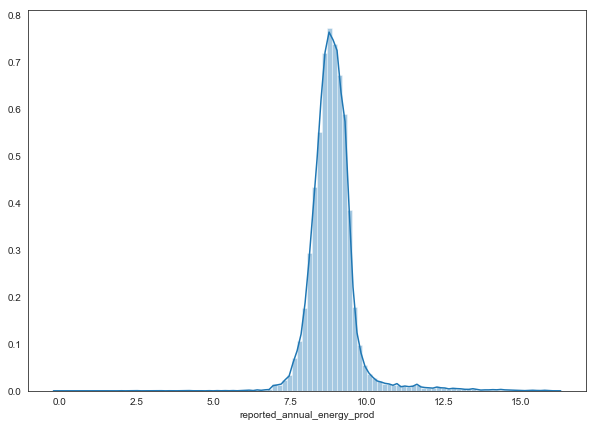

In [14]:
# Taking the log transform of reported annual energy output gives us a really nicely normally distributed target
# Would be nice to use this as the target for modeling or use a poisson regression.

plt.figure(figsize=((10,7)))
log_output = np.log(df['reported_annual_energy_prod'])
sns.distplot(log_output, bins=100)

### Looking at the relationship between size and output

Clearly a very strong linear relationship between size and reported annual energy production

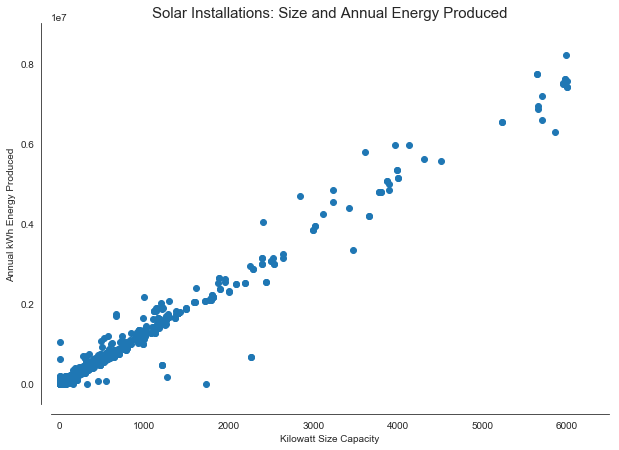

In [15]:
plt.figure(figsize=((10,7)))
plt.scatter(df.size_kw, df.reported_annual_energy_prod)
plt.xlim(-100,6500)
plt.ylim(-500000,.9*10**7)
plt.xlabel("Kilowatt Size Capacity")
plt.ylabel("Annual kWh Energy Produced")
plt.title("Solar Installations: Size and Annual Energy Produced", size=15)
sns.set_style("white")
sns.despine(offset=10, trim=False)

### Comparing NREL predicted Output to Reported Output

It's intersting to compare the NREL 'annual PV prod' and the reported values, given that this is the NREL prediction compared to the actual annual energy produced.  This is where I'm trying to improve in my own modeling.

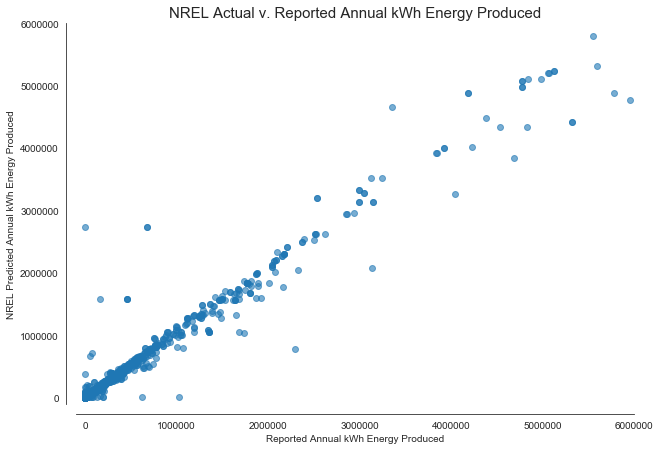

In [16]:
# masking cases where reported and predicted are the same, because in data cleaning I imputed some missing values
# for the NREL predictions using reported data.
mask = df['reported_annual_energy_prod'] != df['annual_PV_prod']

plt.figure(figsize=((10,7)))
plt.scatter(df.loc[mask,'reported_annual_energy_prod'], df.loc[mask,'annual_PV_prod'], alpha=0.6)
plt.xlim(-100000,6000000)
plt.ylim(-100000,6000000)
plt.ylabel("NREL Predicted Annual kWh Energy Produced")
plt.xlabel("Reported Annual kWh Energy Produced")
plt.title("NREL Actual v. Reported Annual kWh Energy Produced", size=15)
sns.set_style("white")
sns.despine(offset=10, trim=False)

# Outliers

There are some values for reported annual energy that are way too high, and I want to remove those from the data to improve predictive accuracy.

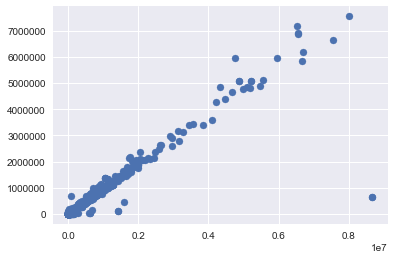

In [252]:
plt.scatter(nrel_y_pred, nrel_y_true)

In [17]:
# Given how connected size and annual energy production is, I'm going to remove any data from the data set where
# efficiency is more than 6 standard deviations from the mean.  Picking a number so high just to be cautious.

# It looks like there must be some installations where efficiency is MUCH higher or lower than the rest.
df['efficiency'] = df['reported_annual_energy_prod'] / df['size_kw']

efficiency_std = df.efficiency.std()
efficiency_mean = df.efficiency.mean()

efficiency_mask = np.abs((efficiency_mean - df['efficiency'])/efficiency_std) < 6

df = df.loc[efficiency_mask, :]

# Partial Correlations

Given that size is such a strong predictor, it's interesting to see what the partial correlations between output and the other features used in the energy output models are.

In [ ]:
# Let's look at all the partial correlations

In [18]:
import numpy as np
from scipy import stats, linalg

# Taken from github
def partial_corr(C):
    """
    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
    for the remaining variables in C.
    Parameters
    ----------
    C : array-like, shape (n, p)
        Array with the different variables. Each column of C is taken as a variable
    Returns
    -------
    P : array-like, shape (p, p)
        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
        for the remaining variables in C.
    """
    
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]

            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
        
    return P_corr

In [19]:
df.columns

Index(['level_0', 'index', 'state', 'incentive_prog_names', 'type', 'size_kw',
       'appraised', 'zipcode', 'install_type', 'installer', 'cost',
       'utility_clean', 'tech_1', 'annual_PV_prod', 'rebate', 'tilt1',
       'tracking_type', 'azimuth1', 'reported_annual_energy_prod',
       'new_constr', 'tracking', '3rdparty', 'bipv', 'efficiency'],
      dtype='object')

In [21]:
partial_corrs_df = df[['size_kw', 'azimuth1', 'tilt1',
                       'reported_annual_energy_prod']]

In [22]:
partial_data = np.array(partial_corrs_df)

In [23]:
partial_corrs = partial_corr(partial_data)

In [24]:
def partial_corr_heat_map(df, title, size):
    partial_data = np.array(df)
    corrs = partial_corr(partial_data)
    
    # set figure size
    fig, ax = plt.subplots(figsize = size)
    
    # generate a mask for the upper triagle 
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    #plot heatmap
    ax = sns.heatmap(corrs, mask=mask, annot = True, cbar=False)
    
    #resize labels
    ax.set_xticklabels(df.columns, fontsize=12, rotation=30)
    ax.set_yticklabels(df.columns[::-1], fontsize=12, rotation=0)
    ax.set_title(title, fontsize=14)
    
    plt.show()

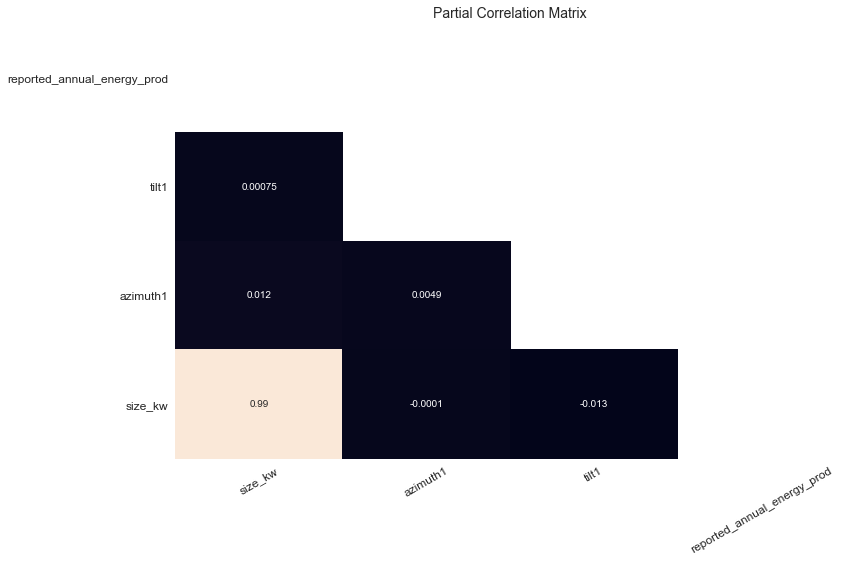

In [25]:
partial_corr_heat_map(partial_corrs_df, "Partial Correlation Matrix", (12,8))

 Surprisingly, there appears to be no more than very slight correlations between the radiation measures (DNI and DHI) and energy production. We might expect — given that we’re talking about solar energy after all — that these factors would play a large role in determining how much energy a solar panel generates. In the U.S., this may not end up being the case because solar radiation is high enough that panels reach their capacity for energy production, and are unable to produce more energy even with more sun exposure. If we were to compare the performance of solar panels in the U.S. to solar panels in the arctic, we might see that radiation is more highly correlated with energy production than we see here.

Like in the scatter plot, there’s again a very strong positive correlation between size and energy production. It is interesting to note that there is a slight negative partial correlation between temperature and energy production. Though temperature obviously correlates highly with areas of high sun exposure, when controlling for the effect of radiation, high temperatures actually cause solar panels to produce energy less efficiently, and degrade more quickly.

In [ ]:
PUT IT HERE

# Modeling Annual Energy Output

The final model I used for production was a random forest regression model, which has several benefits in this context. It is a non-parametric model, which means it can predict a variable that is non-normally distributed. Because there are a wide range of solar panels in the OpenPV dataset, with some utility-scale installations producing thousands of times more energy per year than small, residential panels, the data is very positively skewed. This means that in order to use a model like linear regression without having biased results, it would be necessary to log transform the data, or use a generalized linear model like a poisson regression. Random forest models also do well with categorical features, and in this case there were a few such features, including technology type and tracking type.

The performance of this model was compared against three others, including:
- Ordinary Least-Squares Regression
- Elastic Net Regression
- 2-Layer Feed Forward Neural Network
I built the regression models and the random forest model using Scikit-Learn, and the neural network using Keras with a Tensorflow backend.

### Features

Based on my exploratory analysis, I settled on the following features for my model:
- Kilowatt Size/Capacity 
- Azimuth
- Tilt
- Technology type
- Tracking type
- Diffuse Horizontal Irradiance (DHI)
- Direct Normal Irradiance (DNI)
- Wind Speed

These features are strong predictors of annual output, and are easily obtained for use in a production environment model.



In [6]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

import patsy

<a id='feature-engineering'></a>
# Feature Engineering: Adding Difference From Optimal Tilt

Optimal tilt during the winter is about latitude + 15, and during the winter it's about latitude - 15, so we can approximate optimal tilt using latitude.  To get the amount that the tilt of a solar panel is off from the optimal, we take the absolute value of the difference between the tilt and its latitude.

In [6]:
# rading in a csv that has lat/lon pairs for zipcodes.
zips = pd.read_csv("./free-zipcode-database-Primary.csv")

# joining latitude with main dataframe.
df = df.merge(zips[['Zipcode', 'Lat']], on="Zipcode")

# Calculating optimal tilt difference as absolute value of difference between the tilt and latitude.
df['optimal_tilt_diff'] = np.abs(df['tilt1'] - df['Lat'])

<a id='baseline'></a>
## Calculating Baseline R2

We'll use NREL's annual energy output compared to reported to calculate a baseline r2 score.

In [72]:
from sklearn.metrics import r2_score

In [73]:
X_test_index = X_test.index.values.tolist()

In [74]:
# getting nrel reported and predicted annual pv produced

nrel_y_true = [val[0] for val in y_test.copy().values]
nrel_y_pred = df.ix[X_test_index, 'annual_PV_prod'].values.tolist()

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.


### Baseline Score

In [69]:
from sklearn.metrics import r2_score

In [70]:
r2_score(nrel_y_true, nrel_y_pred)

0.91504295425123838

### Putting this error in $$$

Ultimately, we want to understand how accurate these predictions are in terms of the return one would receive on the energy generated by their solar panel installation.  At an annual average return of 10.24 centers per kilowatt hour, we can calculate the root mean squared error in terms of dollars, and also the median of the absolute error in terms of dollars.  The error is very positively skewed, due to the inclusion of large, utility scale solar installations. Given this skew, the median is going to be a better representation of the amount of error we'd see in predictions for smaller, residential solar customers.

In [76]:
from sklearn.metrics import mean_squared_error

In [77]:
mse_nrel = mean_squared_error(nrel_y_true, nrel_y_pred)

# Root mean squared error dollars
mse_nrel ** 0.5 * .1024

4701.3345001996277

In [78]:
# Calculating median dollars estimate is off in annual returns on solar energy generated.

abs_residuals = np.abs(np.array(nrel_y_true) - np.array(nrel_y_pred))

# avg us rate per kilowatt hour is $.1024
residuals_dollars = abs_residuals * .1024

np.median(residuals_dollars)

61.262380031999946

In [86]:
from scipy.stats import mode

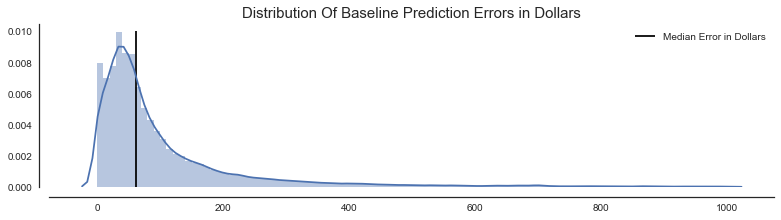

In [93]:
# Plotting the distribution of these errors and looking for the median.

residuals_low = [res for res in residuals_dollars if res < 1000]
plt.figure(figsize=((13,3)))
sns.distplot(residuals_low, bins=100)
plt.title("Distribution Of Baseline Prediction Errors in Dollars", size=15)
plt.vlines(np.median(residuals_dollars), ymin=0, ymax=.01, label="Median Error in Dollars")
sns.set_style("white")
plt.legend()
sns.despine(offset=10, trim=False);

<a id='linear-regression'></a>
## Training a Linear Regression with size_kw alone

Given the importance of size, let's see what kind of score we can get by just doing a linear regression with size.

In [96]:
from sklearn.linear_model import LinearRegression

In [97]:
lin_reg = LinearRegression()

In [98]:
size_kw_index = None

for i, c in enumerate(X.columns):
    if c == "size_kw":
        size_kw_index = i

size_kw_index

15

In [99]:
# Getting training data into correct shape to fit the model.
size_kw_train = np.array(X_train.loc[:, size_kw_index].values).reshape((len(X_train),1))

lin_reg.fit(size_kw_train, np.array(y_train).ravel())

//anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [100]:
# Getting testing data into correct shape to fit the model.
size_kw_test = np.array(X_test.loc[:, size_kw_index].values).reshape((len(X_test),1))
lin_reg.score(size_kw_test, np.array(y_test).ravel())

0.92907346868194052

In [101]:
from sklearn.metrics import mean_squared_error

In [102]:
# What does this improvement mean in dollars annually?

lr_pred = lin_reg.predict(size_kw_test)
mse_lr = mean_squared_error(np.array(y_test), lr_pred)

# Root mean squared error dollars
mse_lr ** 0.5 * .1024

4295.6195659638724

In [103]:
lr_residuals_abs = np.abs(np.array(y_test.values).ravel() - lr_pred)
# median absolute value error in dollars

np.median(lr_residuals_abs * .1024)

150.06259129211793

### Building Design Matrices + train/test split for other models

I used patsy to build my design matrices.  Patsy automatically one hot encodes categorical features like technology and tracking type, and splits our data into X and y dataframes.

In all my models, I'm using a random state of 25 when splitting data into training and testing sets, so that I can completely objectively score each model against one another after training

In [23]:
formula = """\
reported_annual_energy_prod ~ size_kw + azimuth1 + optimal_tilt_diff + tech_1 + DHI + DNI + Wind_Speed + tracking_type"""

print 'splitting into X and y design matrices'
y, X = patsy.dmatrices(formula, df, return_type='dataframe')

scaler = StandardScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(X))

# not using this, just doing a built in evaluation split.
print 'splitting into train and test'

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=.75, random_state=25)

splitting into X and y design matrices


<a id='elastic-net'></a>

## Training Elastic Net Model

The linear regression model performed better than the baseline model, but given that this is solar energy, and that we do see pretty strong correlations between irradiance factors and efficiency, it seems likely that building a more complex model that includes these other factors could improve the accuracy of our predictions.

In [99]:
# creating a gridsearch to find optimal elastic net parameters.

params = {
    'alpha': np.linspace(0.08,.15,5),
}
en = ElasticNet(.95)
gs_en = GridSearchCV(en, params, cv=8, verbose=1)

In [100]:
gs_en.fit(X_train, y_train)

Fitting 8 folds for each of 5 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   35.6s finished


GridSearchCV(cv=8, error_score='raise',
       estimator=ElasticNet(alpha=0.95, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([ 0.08  ,  0.0975,  0.115 ,  0.1325,  0.15  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [102]:
gs_en.best_score_

0.92139789975183162

In [104]:
gs_en.best_params_

{'alpha': 0.080000000000000002}

In [103]:
gs_en.score(X_test, y_test)

0.90262400157114253

In [105]:
# expanding gridsearch, since optimal alpha was the lowest possible value from previous grid search parameters.

params = {
    'alpha': np.linspace(0.01,.08,8),
    'l1_ratio': np.linspace(.8,1,4)
}
en = ElasticNet()
gs_en = GridSearchCV(en, params, cv=8, verbose=1)

gs_en.fit(X_train, y_train)

Fitting 8 folds for each of 32 candidates, totalling 256 fits


[Parallel(n_jobs=1)]: Done 256 out of 256 | elapsed: 27.9min finished


GridSearchCV(cv=8, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([ 0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08]), 'l1_ratio': array([ 0.8    ,  0.86667,  0.93333,  1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [106]:
gs_en.best_params_

{'alpha': 0.080000000000000002, 'l1_ratio': 0.80000000000000004}

In [108]:
gs_en.best_score_

0.92184461143995367

In [282]:
gs_en.score(X_test, y_test)

# Our score is not getting better on the testing data.

0.91049939610329389

In [22]:
en = ElasticNet(alpha=.08, l1_ratio=0.8)
en.fit(X_train, y_train)

ElasticNet(alpha=0.08, copy_X=True, fit_intercept=True, l1_ratio=0.8,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [172]:
# saving the model.

en_filename = 'finalized_en_model.sav'
pickle.dump(en, open(en_filename, 'wb'))

### Score for Elastic Net Model

The R2 score of the elastic net model on the validation data is no better than the linear regression model using size alone.  In this model, size dominates our predictions, and is by far the most important factor in determining annual output.  There does appear to be a slight negative effect of diffuse horizontal irradiance.  This makes sense, given that diffuse irradiance is higher in areas where there is more cloud cover and particulates in the air.

In [23]:
en.score(X_test, y_test)

0.9293679750648387

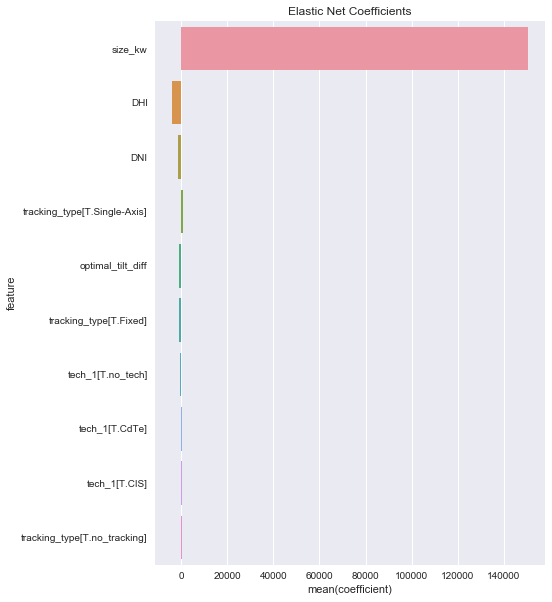

In [60]:
# plotting elastic net coefficients.

coefs = pd.DataFrame({
    'feature': X.columns,
    'coefficient': en.coef_,
    'abs_coef': np.abs(en.coef_)
})
coefs.sort_values('abs_coef', inplace=True, ascending=False)

plt.figure(figsize=(7,10))
sns.barplot(x=coefs.coefficient.head(10), y=coefs.feature.head(10), orient='h')
plt.title("Elastic Net Coefficients")

### What does this improvement mean in dollars annually?

In [28]:
en_pred = en.predict(X_test)
mse_en = mean_squared_error(np.array(nrel_y_true), en_pred)

# Root mean squared error dollars
mse_en ** 0.5 * .1024

4286.6919944469637

In [29]:
en_residuals_abs = np.abs(np.array(nrel_y_true) - en_pred)
# median absolute value error in dollars

np.median(en_residuals_abs * .1024)

158.6822585401917

<a id='random-forest'></a>
## Training Random Forest Model

In [113]:
rand_forest = RandomForestRegressor(n_estimators=150)

# Creating gridsearch to find optimal parameters.
params = {
    'max_depth': [65,70,75,80,90],
    'max_features': [10,11,12]
}

gs_rf = GridSearchCV(rand_forest, params, cv=8, verbose=1)

In [31]:
# making a new train/test split that's not normalized.
# Random forest does not require scaled data like linear regression.

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=25)

In [116]:
gs_rf.fit(X_train, y_train)

Fitting 8 folds for each of 15 candidates, totalling 120 fits


//anaconda/lib/python2.7/site-packages/sklearn/model_selection/_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 194.6min finished
//anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  best_estimator.fit(X, y, **self.fit_params)


GridSearchCV(cv=8, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [10, 11, 12], 'max_depth': [65, 70, 75, 80, 90]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [117]:
gs_rf.best_score_

0.91866230060217668

In [118]:
gs_rf.score(X_test, y_test)

0.9487661780415132

In [119]:
gs_rf.best_params_

{'max_depth': 65, 'max_features': 11}

In [ ]:
# Let's try some different params, since max depth was the lowest level we gave it.

In [120]:
params = {
    'max_depth': [60,62,65],
    'max_features': [10,11,12]
}

gs_rf = GridSearchCV(rand_forest, params, cv=8, verbose=1)

In [121]:
gs_rf.fit(X_train, y_train)

Fitting 8 folds for each of 9 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 120.9min finished


GridSearchCV(cv=8, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [10, 11, 12], 'max_depth': [60, 62, 65]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [122]:
gs_rf.best_params_

{'max_depth': 62, 'max_features': 12}

In [123]:
gs_rf.best_score_

0.91995480462950152

### Score for RF model:

In [32]:
rf = RandomForestRegressor(n_estimators=150, max_depth=62, max_features=12)

%time rf.fit(X_train, y_train)

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


CPU times: user 2min 4s, sys: 2.31 s, total: 2min 6s
Wall time: 2min 11s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=62,
           max_features=12, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [34]:
rf.score(X_test, y_test)

0.97305201121015517

In [ ]:
# saving this model.
import pickle

filename = 'finalized_rf_model.sav'
pickle.dump(rf, open(filename, 'wb'))

In [19]:
import pickle
from pickle import load

In [20]:
filename = 'finalized_rf_model.sav'
rf = pickle.load(open(filename, 'rb'))

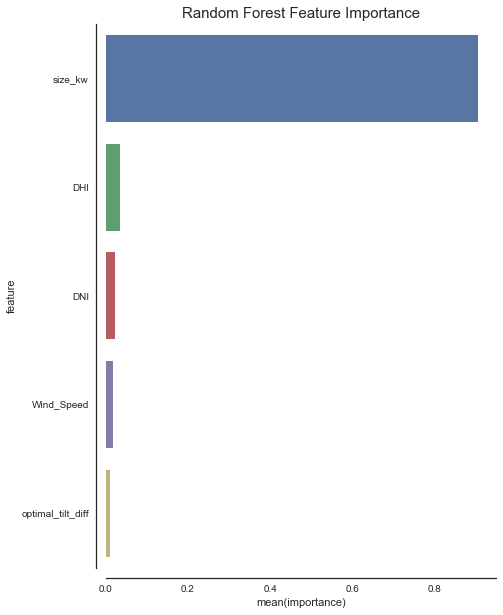

In [54]:
feature_imports = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
})

feature_imports.sort_values("importance", inplace=True, ascending=False)
plt.figure(figsize=(7,10))
sns.barplot(x=feature_imports.importance.head(5), y=feature_imports.feature.head(5), orient='h')
plt.title("Random Forest Feature Importance", size=15)
sns.set_style("white")
sns.despine(offset=10, trim=False);

### Results

Using the random forest model, I achieved an R² value of .973 on validation data. The validation data were the same values used to generate the baseline score, so the comparison is completely like-to-like. In terms of annual savings, the median error drops from the baseline of $60.00 to +/- approximately $15.00 in predicted savings on energy.

Figure 7. Feature importances of the random forest model
Feature importances of a random forest model are a clear and easy way to interpret how much different variables contribute to predictions. More specifically, in Figure 7. they show the percent increase to mean squared error were a variable to be excluded from the model. We see that size contributes the most to predicting energy production, with an 87% importance. Direct and diffuse irradiance also play a role. These findings indicate that while it’s most important to build as large an installation as possible, building in places with high direct irradiance and low diffuse irradiance will help to produce more energy. Wind speed also plays a role, likely because high wind speeds correlate with areas of less shade, and high winds keep debris from collecting on panels. The last feature here is optimal tilt difference, which plays a comparatively small role in determining energy output. The more off a solar panel is from its optimal tilt, the less energy it will generate. Other factors in the model have a negligible importance.


In [38]:
rf_pred = rf.predict(X_test)

In [39]:
mse_rf = mean_squared_error(nrel_y_true, rf_pred)

# Root mean squared error dollars
mse_rf ** 0.5 * .1024

2647.7966620365455

In [40]:
# Calculating median dollars estimate is off in annual returns on solar energy generated.

abs_residuals = np.abs(np.array(nrel_y_true) - np.array(rf_pred))

# avg us rate per kilowatt hour is $.1024
residuals_dollars = abs_residuals * .1024

np.median(residuals_dollars)

15.446016000000016

### Looking For Bias

There may be bias in this model, particularly because one feature dominates the predictions so heavily, and because the target variable is so positively skewed.  We can plot the residuals to investigate this.


In [28]:
# Calculating predicted values for whole X
rf_pred = rf.predict(X)

# Getting y true values
y_vals = np.array([val[0] for val in y.values])

# calculating residuals
rf_residuals = rf_pred - y_vals

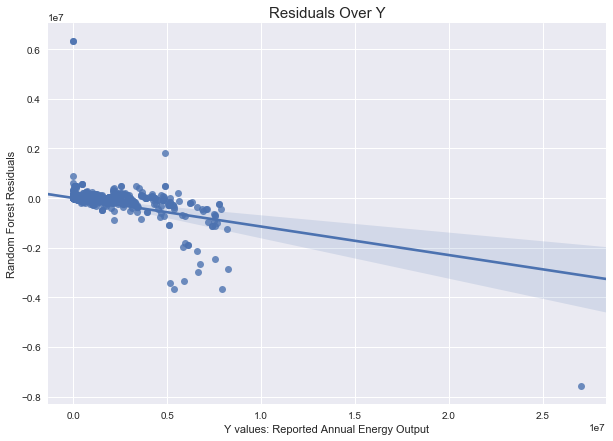

In [46]:
plt.figure(figsize=(10,7))
sns.regplot(y_vals, np.array(rf_residuals))
plt.title("Residuals Over Y", size=15)
plt.xlabel("Y values: Reported Annual Energy Output")
plt.ylabel("Random Forest Residuals")

There does appear to be quite a bit of bias in the residuals, with a pretty strong downward trend as y increases.
We may want to limit the model to smaller sized installations or log transform output to mitigate this.


<a id='neural-net'></a>
## Neural Net Model

This neural net model scored a .925 R2 on the testing data, failing to outperform the random forest model.  After extensive tuning I was unable to get the R2 over this amount.  Given the time required to train and tune this model, it's lack of interpretability, and the strength of the models I've already built, I decided to move on from this, and use the random forest model in production for my web app.

In [165]:
import keras
import keras.backend as K
#K._BACKEND == 'tensorflow'

import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback

import patsy
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


//anaconda/lib/python2.7/site-packages/dask/dataframe/hashing.py:6: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import is_bool_array


AttributeError: 'module' object has no attribute 'computation'

In [ ]:
# this is a custom r2 function to use in the model for evaluating performance
def custom_r2(y_true, y_pred):
    baseline = K.sum((y_true - K.mean(y_true))**2)
    model_fit = K.sum((y_true - y_pred)**2)
    return 1. - model_fit/baseline

In [ ]:
# Building Neural Net Model:
model = Sequential()

model.add(Dense(1024, input_shape=(21,), kernel_initializer='normal'))
model.add(Activation('elu'))
model.add(Dropout(.2))

model.add(Dense(1024, kernel_initializer='normal'))
model.add(Activation('elu'))
model.add(Dropout(.5))

model.add(Dense(1, kernel_initializer='normal'))
model.add(Activation('linear'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=[custom_r2])

In [ ]:
def early_stopping_cont_nn(model, X, y, val_data, batch_size=1, verbose=1, epochs_per_iter=1, max_iterations=10,
                           patience=3, min_delta=.1):
    """DOCSTRING:
    This function takes a keras neural net model predicting a continuous variable, with a custom r2 function as
    the evaluation metric.  It will check the change to the r2 value and do an early stop if the r2 does not change by
    the amount specifed in min delta.

    - model: keras model to fit.
    - X: numpy array of X training data.
    - y: numpy array of y training data.
    - val_data: (tuple) of numpy arrays of X and y validation data.
    - batch_size: batch size for keras model fitting.
    - verbose: 0/1 for whether keras model fitting is verbose.
    - epochs_per_iteration: (int) How many epochs to fit before checking to see if the evaluation metric has change\
                enough to continue
    - max_iterations: (int) How many iterations through the specified epochs before automatically stopping fitting.
    - patience: (int) How many iterations can have less than the specified delta to the evaluation metric before stopping.
    - min_delta: (int/float) How much evaluation metric must change by at minimum not to raise patience level.
    """

    # if our model doesn't improve by a certain amount for 'patience' times, we'll break the fitting.
    current_patience = 0
    last_r2 = 0

    for i in range(max_iterations):
        model.fit(x=X, y=y, validation_data = val_data, batch_size=batch_size, verbose=verbose, epochs=epochs_per_iter)

        current_r2 = r2_score(y_test, model.predict(np.array(X_test)))
        print "current r2: ", current_r2
        print "-----------------------"
        r2_diff = current_r2 - last_r2

        print "R2 improvement: ", r2_diff
        print "-----------------------"
        if r2_diff < min_delta:
            print "Improvement Does Not Meet Minimum, Adding One to Patience Score"
            print "-----------------------"
            current_patience += 1
        if current_patience >= patience:
            print "Stopping training, patience threshold met"
            break
        last_r2 = current_r2

print 'Training model!'

# Calling the function we just wrote.  May need to tune batch size, min_delta, as well as the model.
early_stopping_cont_nn(model, X=np.array(X_train), y=np.array(y_train).ravel(),
                       val_data=(np.array(X_test), np.array(y_test).ravel()), epochs_per_iter=1,
                       batch_size=500, verbose=1, max_iterations=1000, min_delta=.0005, patience=2)

print r2_score(y_test, model.predict(np.array(X_test)))

model.save('./neural_net_models/nn_2_wide.h5')

<a id='output-size'></a>
# Modeling Output/Size

Because size dominates the performance of the models when used as a predictive factor, I built a regression model predicting output per unit size to gain a more granular understanding of the relationship between other factors and energy production. Though this model performs more poorly than when size is included as a feature, it helps demonstrate the effect of radiation and installation factors on output. The model scores an R² of .683 on validation data.

In [55]:
from sklearn.preprocessing import MinMaxScaler

formula = """\
efficiency ~ azimuth1 + optimal_tilt_diff + tech_1 + DHI + DNI + Wind_Speed + tracking_type"""

print 'splitting into X and y design matrices'
y, X = patsy.dmatrices(formula, df, return_type='dataframe')

scaler = MinMaxScaler()

X_scaled = X.copy()

for c in X.columns:
    if "[" not in c:
        X_scaled[c] = scaler.fit_transform(X[c].values)

# not using this, just doing a built in evaluation split.
print 'splitting into train and test'

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=.75, random_state=25)

splitting into X and y design matrices


//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

splitting into train and test


In [59]:
# expanding gridsearch, since optimal alpha was the lowest possible value from previous grid search parameters.

params = {
    'alpha': np.linspace(0.1,1,11),
    'l1_ratio': np.linspace(.5,1,6)
}
en = ElasticNet()
gs_en = GridSearchCV(en, params, cv=8, verbose=1)

gs_en.fit(X_train, y_train)

Fitting 8 folds for each of 66 candidates, totalling 528 fits


[Parallel(n_jobs=1)]: Done 528 out of 528 | elapsed:  2.5min finished


GridSearchCV(cv=8, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([ 0.1 ,  0.19,  0.28,  0.37,  0.46,  0.55,  0.64,  0.73,  0.82,
        0.91,  1.  ]), 'l1_ratio': array([ 0.5,  0.6,  0.7,  0.8,  0.9,  1. ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [60]:
gs_en.score(X_test, y_test)

0.68284032062513589

In [61]:
en_efficiency = ElasticNet(alpha=gs_en.best_params_['alpha'], l1_ratio=1)
en_efficiency.fit(X_scaled, y)

ElasticNet(alpha=0.10000000000000001, copy_X=True, fit_intercept=True,
      l1_ratio=1, max_iter=1000, normalize=False, positive=False,
      precompute=False, random_state=None, selection='cyclic', tol=0.0001,
      warm_start=False)

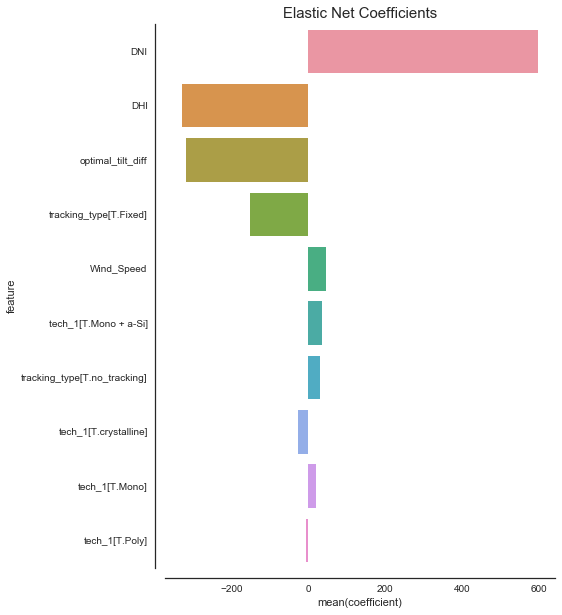

In [62]:
# plotting elastic net coefficients.

coefs = pd.DataFrame({
    'feature': X.columns,
    'coefficient': en_efficiency.coef_,
    'abs_coef': np.abs(en_efficiency.coef_)
})
coefs.sort_values('abs_coef', inplace=True, ascending=False)

plt.figure(figsize=(7,10))
sns.barplot(x=coefs.coefficient.head(10), y=coefs.feature.head(10), orient='h')
plt.title("Elastic Net Coefficients", size=15)
sns.set_style("white")
sns.despine(offset=10, trim=False)

Looking at the coefficients for this model show how much positive or negative effect an increase in each factor has on annual energy production per unit size of an installation. Direct irradiance is the most important feature, with a large positive impact. Both diffuse irradiance and optimal tilt difference have substantial negative impacts on energy output, which is a fairly intuitive result. We see that a solar panel with fixed tracking will produce less energy as well, because a panel that does not track will have less exposure to radiation. Presumably it requires energy to operate a tracking solar panel, and this finding suggests that generally, the energy generated from tracking outweighs the energy required to operate the tracking system. Finally, mono-crystalline panels outperform poly-crystalline. We see this result because mono panels contain purer silicon, which leads to increased efficiency.

<a id='cost-model'></a>

# Modeling Installation Cost

We also want to develop a model for predicting installation cost.  We'll use size, installer, tracking, technology, and install type in our model.  Unfortunately, the cost variable included in the OpenPV dataset is pre-incentive and pre-rebate installation cost, but we can at least get an idea of how much installation will cost.

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


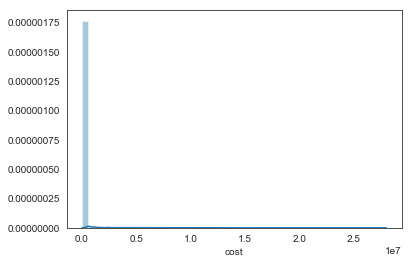

In [26]:
# Let's look at the distribution of our target variable.

# Looks very positively skewed.
plt.figure(figsize=(6,4))
sns.distplot(df.cost)

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


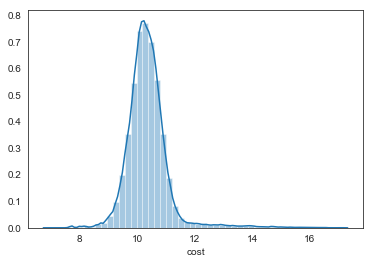

In [27]:
# Again, a log transform seems to do a good job of getting the target variable into a normal distribution.

plt.figure(figsize=(6,4))
sns.distplot(np.log(df.cost))

In [28]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
# plotting size with cost

# Like with energy output, there's a very strong positive correlation between size and cost, indicating that size 
# will have a lot of importance in predicting cost.

(-1000000, 25000000)

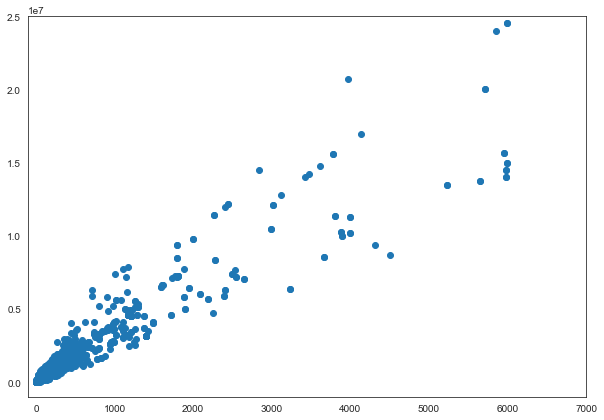

In [29]:
plt.figure(figsize=(10,7))
plt.scatter(df['size_kw'], df['cost'])
plt.xlim(-100,7000)
plt.ylim(-1000000,25000000)

In [ ]:
# Plotting cost/size over time

# I'd imagine that cost/size, cost per unit size, has come down over time.  Let's see if that's the case.
# If it is, we may want to restrict the data in our model to just recent installations to reflect the current cost
# of technology.

In [30]:
df['cost_over_size'] = df['cost'] / df['size_kw']

df[['year_installed', 'cost_over_size']].groupby('year_installed').mean().plot(figsize=(10,7))

# Looks like cost over size has come way down.  Let's limit the data to just 2013 and on.

KeyError: "['year_installed'] not in index"

In [10]:
df_cost = df[df['year_installed'] >= 2013]

### Building Design Matrices

### Feature Selection
I chose the following features for modeling installation cost.
- size
- install type (residential, commercial, etc.)
- installer (which company)
- technology
- tracking

In [33]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import patsy

In [35]:
formula = "cost ~ size_kw + install_type + installer + tech_1 + tracking_type"

print('splitting into X and y design matrices')
y, X = patsy.dmatrices(formula, df, return_type='dataframe')

scaler = MinMaxScaler()

X_scaled = X.copy()

for c in X_scaled.columns:
    if '[' not in c:
        X_scaled[c] = scaler.fit_transform(X_scaled[c])
        

# not using this, just doing a built in evaluation split.
print('splitting into train and test')

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=.75)

splitting into X and y design matrices


ValueError: Expected 2D array, got 1D array instead:
array=[1. 1. 1. ... 1. 1. 1.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [15]:
# Going to use Lasso regularization, which should do well at handling all the encoded features for installers.

In [8]:
from sklearn.linear_model import LassoCV

In [24]:
lasso_cv = LassoCV(cv=5)

lasso_cv.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [25]:
# We got a pretty solid model here.
lasso_cv.score(X_test, y_test)

0.95144314225998317

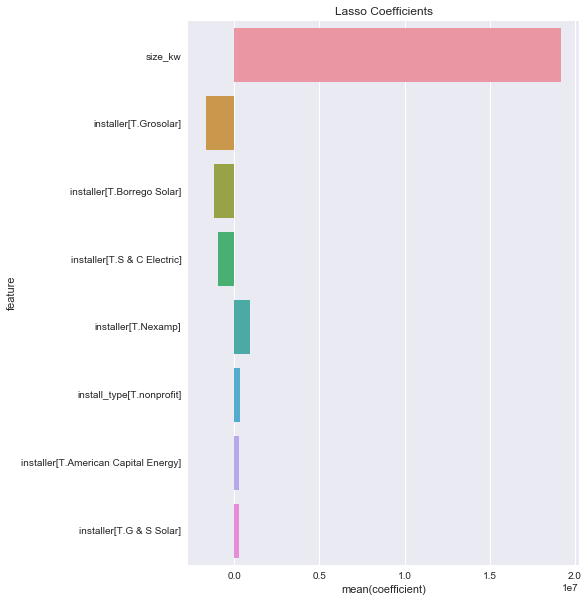

In [31]:
# plotting elastic net coefficients.

coefs = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lasso_cv.coef_,
    'abs_coef': np.abs(lasso_cv.coef_)
})
coefs.sort_values('abs_coef', inplace=True, ascending=False)

plt.figure(figsize=(7,10))
sns.barplot(x=coefs.coefficient.head(8), y=coefs.feature.head(8), orient='h')
plt.title("Lasso Coefficients")

## Interpreting Results

Like with predicting energy output, size is the biggest determinant of installation cost.  It's pretty intuitive that the bigger an installation, the more it would cost to install.  Beyond that, installers determine installation cost.  Positive and negative coefficients here correspond to installers who offer better or worse than average pricing.  It's interesting to note that features like tracking and technology don't show up highly, indicating that those factors don't have a huge impact on price.  It therefore seems to make sense to choose more efficient technologies like monocrystalline silicon and to install tracking on panels.

## Examining Residuals

I want to plot the residuals to see if there's any bias in the model.  We get a very high R2 value, almost suspciously high.  Considering that and that one coefficient dominates the prediction, there may be bias in the model.  After looking at these residuals, it does appear as though there's some bias in the model.  Given the bias, I may want to try do log cost as the target variable if I was going to perfect this model.

In [39]:
y_vals = [val[0] for val in y.values]
y_pred = lasso_cv.predict(X_scaled)

residuals = y_vals - y_pred

In [ ]:
# There does appear to be a bit of bias in this model.  The residuals get larger as the y values get larger.
# At a certain point, none of the residuals are negative, and they get more and more positive.  The outer bounds of the
# regression line are also all above 0, showing that it's 95% likely that the mean of the residuals is greater than 0.

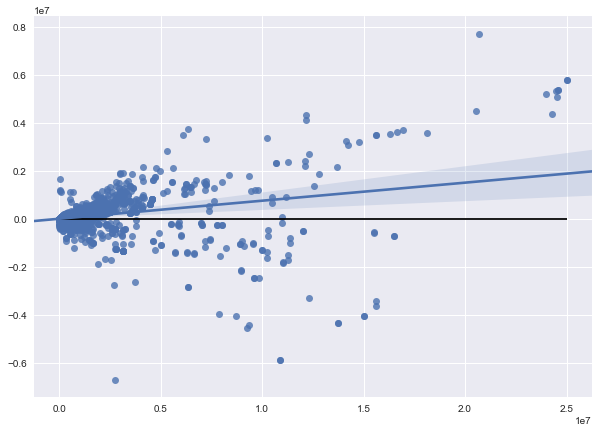

In [61]:
plt.figure(figsize=(10,7))
sns.regplot(np.array(y_vals), residuals)

# plotting a horizontal line for the mean of the residuals
plt.hlines(y=np.mean(residuals), xmin=0, xmax=25000000)

# Legacy Code

### Partial correlation of just DNI


In [ ]:
# we need to regress all the variables with DNI and Output and then correlate the residuals.

In [5]:
# # First we need to make new dataframes for thre regressions with no DNI

# formula = "reported_annual_energy_prod ~ size_kw + azimuth1 + tilt1 + tech_1 + DHI + Wind_Speed + tracking_type"

# print 'splitting into X and y design matrices'
# y, X = patsy.dmatrices(formula, df, return_type='dataframe')

# scaler = StandardScaler()

# X_scaled = pd.DataFrame(scaler.fit_transform(X))

# # not using this, just doing a built in evaluation split.
# print 'splitting into train and test'

# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=.75, random_state=25)

splitting into X and y design matrices
splitting into train and test


In [6]:
# # just going to use the same parameters from the earlier elastic net model
# en_pc_1 = ElasticNet(alpha=.08, l1_ratio=0.8)

In [7]:
# en_pc_1.fit(X_train, y_train)

ElasticNet(alpha=0.08, copy_X=True, fit_intercept=True, l1_ratio=0.8,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [8]:
# en_pc_1.score(X_test, y_test)

0.92935728635807624

In [13]:
# y_test_vals = np.array([val[0] for val in y_test.values])

array([ 13153.64781254,   8096.20823422,   4819.98939862, ...,
         6548.46648003,  16124.46566739,  12426.46498605])

In [16]:
# pc_1_residuals = y_test_vals - en_pc_1.predict(X_test)

In [ ]:
# Now we need residuals of all the variables regressed against DNI

In [17]:
# formula = "DNI ~ size_kw + azimuth1 + tilt1 + tech_1 + DHI + Wind_Speed + tracking_type"

# print 'splitting into X and y design matrices'
# y, X = patsy.dmatrices(formula, df, return_type='dataframe')

# scaler = StandardScaler()

# X_scaled = pd.DataFrame(scaler.fit_transform(X))

# # not using this, just doing a built in evaluation split.
# print 'splitting into train and test'

# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=.75, random_state=25)

splitting into X and y design matrices
splitting into train and test


In [19]:
# # just going to use the same parameters from the earlier elastic net model
# en_pc_2 = ElasticNet(alpha=.08, l1_ratio=0.8)

In [20]:
# en_pc_2.fit(X_train, y_train)

ElasticNet(alpha=0.08, copy_X=True, fit_intercept=True, l1_ratio=0.8,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [21]:
# en_pc_2.score(X_test, y_test)

0.82137588088174662

In [22]:
# y_test_vals_2 = np.array([val[0] for val in y_test.values])

# pc_2_residuals = y_test_vals_2 - en_pc_2.predict(X_test)

In [23]:
# from scipy.stats import pearsonr

In [24]:
# pearsonr(pc_1_residuals, pc_2_residuals)

(-0.013302328599936315, 0.002747875584863003)

### Regressing Against Output Without Size

Want to see how well we can predict output without using size, and get a better idea of the affect of some of the features that are so heavily outweighed by size in other models.

In [71]:
# from sklearn.preprocessing import MinMaxScaler

In [72]:
# formula = "reported_annual_energy_prod ~ azimuth1 + tilt1 + tech_1 + DHI + DNI + Wind_Speed + tracking_type"

# print 'splitting into X and y design matrices'
# y, X = patsy.dmatrices(formula, df, return_type='dataframe')

# scaler = MinMaxScaler()

# X_scaled = X.copy()

# for c in X.columns:
#     if "[" not in c:
#         X_scaled[c] = scaler.fit_transform(X[c].values)

# # not using this, just doing a built in evaluation split.
# print 'splitting into train and test'

# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=.75, random_state=25)

splitting into X and y design matrices
splitting into train and test


//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

In [73]:
# # Well that did incredibly badly.
# lasso_cv = LassoCV()
# lasso_cv.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [74]:
# lasso_cv.score(X_test, y_test)

0.0031269992983831152

In [75]:
# lasso = Lasso(alpha=lasso_cv.alpha_)
# lasso.fit(X_train, y_train)

Lasso(alpha=1.478029412624295, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

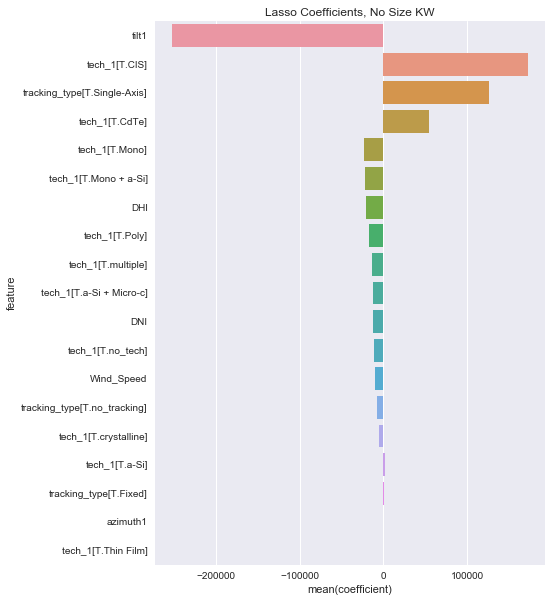

In [76]:
# # plotting Lasso coefficients, in standard deviation scale.


# coefs = pd.DataFrame({
#     'feature': X.columns,
#     'coefficient': lasso.coef_,
#     'abs_coef': np.abs(lasso.coef_)
# })

# coefs.sort_values('abs_coef', inplace=True, ascending=False)

# plt.figure(figsize=(7,10))
# sns.barplot(x=coefs.coefficient.head(19), y=coefs.feature.head(19), orient='h')
# plt.title("Lasso Coefficients, No Size KW")

In [77]:
# lasso.score(X_test, y_test)

0.0031269992983831152

### Outlier stuff

In [27]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# %matplotlib inline

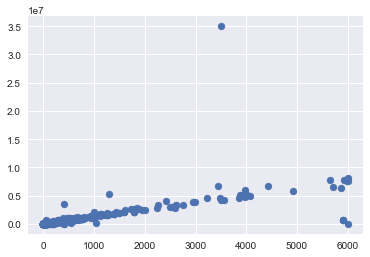

In [28]:
# There's a huge outlier here.

# plt.scatter(X_test.size_kw, y_test)

In [31]:
# y_test.sort_values('reported_annual_energy_prod', ascending=False)

,reported_annual_energy_prod
436695,3.500000e+07
442040,8.205000e+06
431983,7.847000e+06
426115,7.735000e+06
445163,7.551000e+06
425685,7.518734e+06
442762,6.743125e+06
772975,6.632955e+06
461770,6.578451e+06
452292,6.290689e+06


In [29]:
# y.columns

Index([u'reported_annual_energy_prod'], dtype='object')

In [30]:
# type(y_test)

pandas.core.frame.DataFrame

In [36]:
# df.loc[df['reported_annual_energy_prod'] > 1*10**7]

,state,incentive_prog_names,type,size_kw,appraised,zipcode,install_type,installer,cost,utility_clean,...,third_party,bipv,year_installed,DHI,DNI,GHI,Solar_Zenith_Angle,Temperature,Wind_Speed,Zipcode
145973,AZ,Arizona Public Service,uir,18000.0,0.0,86321,residential,SolarCity,7.369182e+07,Arizona Public Service,...,0.0,0.0,2011.0,55.154909,301.173402,232.856963,89.715297,19.075935,2.602529,86321
436695,MA,Massachusetts Department of Energy Resources,uir,3493.6,0.0,1331,commercial,Epcse Solar Corp,1.256500e+07,National Grid,...,0.0,0.0,2013.0,63.192123,198.892580,169.642123,89.682661,8.675551,0.895853,1331


In [37]:
# df.iloc[145973, :]

state                                              AZ
incentive_prog_names           Arizona Public Service
type                                              uir
size_kw                                         18000
appraised                                           0
zipcode                                         86321
install_type                              residential
installer                                   SolarCity
cost                                      7.36918e+07
utility_clean                  Arizona Public Service
tech_1                                        no_tech
annual_PV_prod                            3.06305e+07
rebate                                              0
tilt1                                              22
tracking_type                             no_tracking
azimuth1                                          180
reported_annual_energy_prod                   2.7e+07
new_constr                                          0
tracking                    

In [43]:
# # I'm going to eliminate these rows as outliers, they're overreporting how much energy they're producing.

# df.loc[df['reported_annual_energy_prod'] - df['annual_PV_prod'] < 2*10**6]

,state,incentive_prog_names,type,size_kw,appraised,zipcode,install_type,installer,cost,utility_clean,...,third_party,bipv,year_installed,DHI,DNI,GHI,Solar_Zenith_Angle,Temperature,Wind_Speed,Zipcode
414240,MA,Massachusetts Clean Energy Center,uir,3580.720,0.0,2093,nonprofit,Florence Electric,7.855127e+06,National Grid,...,1.0,0.0,2013.0,64.018607,195.797945,169.773174,89.684537,10.425683,0.882835,2093
433871,MA,Massachusetts Department of Energy Resources,uir,1287.000,0.0,1844,commercial,Borrego Solar,4.697551e+06,National Grid,...,0.0,0.0,2013.0,61.994521,202.102740,170.576027,89.682099,9.814643,0.889159,1844
434192,MA,Massachusetts Clean Energy Center,uir,1287.000,0.0,1844,commercial,Borrego Solar,4.697551e+06,National Grid,...,0.0,0.0,2013.0,61.994521,202.102740,170.576027,89.682099,9.814643,0.889159,1844
436695,MA,Massachusetts Department of Energy Resources,uir,3493.600,0.0,1331,commercial,Epcse Solar Corp,1.256500e+07,National Grid,...,0.0,0.0,2013.0,63.192123,198.892580,169.642123,89.682661,8.675551,0.895853,1331
442762,MA,Massachusetts Department of Energy Resources,uir,3443.365,0.0,1462,residential,"IESI, Inc",1.410869e+07,Unitil,...,1.0,0.0,2014.0,62.824087,200.198288,169.991781,89.682671,9.049544,0.895853,1462
620816,CA,Imperial Irrigation District,uir,400.000,0.0,92231,residential,SolarCity,1.651601e+06,Imperial Irrigation District,...,0.0,0.0,2011.0,52.784132,317.561187,245.184247,89.723793,23.820224,2.524194,92231
621181,CA,Imperial Irrigation District,uir,400.000,0.0,92243,residential,SolarCity,1.651601e+06,Imperial Irrigation District,...,0.0,0.0,2011.0,53.166438,315.838356,243.658676,89.723408,23.632665,2.656314,92243
621417,CA,Imperial Irrigation District,uir,400.000,0.0,92253,residential,SolarCity,1.651601e+06,Imperial Irrigation District,...,0.0,0.0,2011.0,53.451826,311.637900,241.055023,89.719246,20.921113,2.838593,92253


## Redoing Cost Model With Log Cost

In [ ]:
# Redoing this model with log size and cost

In [11]:
df_cost['log_cost'] = np.log(df.cost)
df_cost['log_size'] = np.log(df.size_kw)

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
formula = "log_cost ~ log_size + install_type + installer + tech_1 + tracking_type"

print 'splitting into X and y design matrices'
y, X = patsy.dmatrices(formula, df_cost, return_type='dataframe')

scaler = MinMaxScaler()

X_scaled = X.copy()

for c in X_scaled.columns:
    if '[' not in c:
        X_scaled[c] = scaler.fit_transform(X_scaled[c])
        

# not using this, just doing a built in evaluation split.
print 'splitting into train and test'

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=.75)

splitting into X and y design matrices


//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

splitting into train and test


In [15]:
lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X_train, y_train)

//anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [16]:
# This model does not perform quite as well with regard to r2 as the model using non-log transformed target.

# That being said, if the residuals are not biased then this model may be preferable.

lasso_cv.score(X_test, y_test)

0.88750104613823422

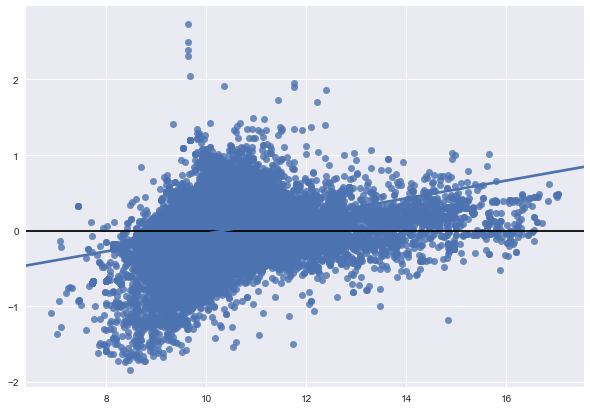

In [17]:
y_vals = [val[0] for val in y.values]
y_pred = lasso_cv.predict(X_scaled)

residuals = y_vals - y_pred

plt.figure(figsize=(10,7))
sns.regplot(np.array(y_vals), residuals)

# plotting a horizontal line for the mean of the residuals
plt.hlines(y=np.mean(residuals), xmin=0, xmax=25000000)

# Even when log transforming the target variable and size, there still appears to be a pretty clear bias in the model,
# with a positive trend in the residuals

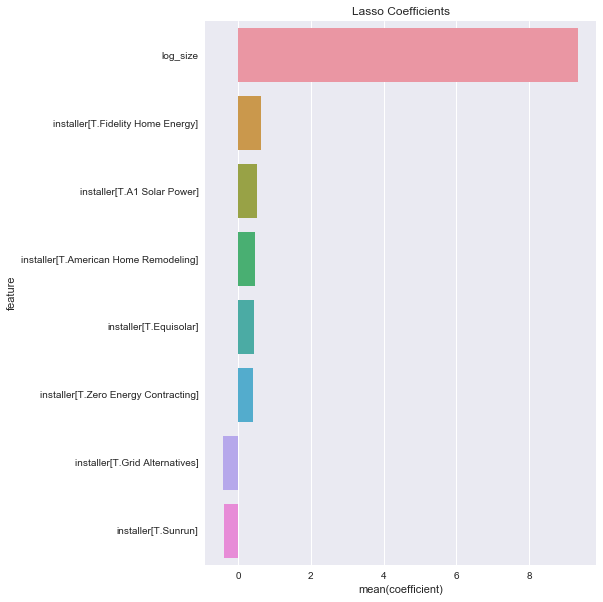

In [18]:
# plotting elastic net coefficients.

coefs = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lasso_cv.coef_,
    'abs_coef': np.abs(lasso_cv.coef_)
})
coefs.sort_values('abs_coef', inplace=True, ascending=False)

plt.figure(figsize=(7,10))
sns.barplot(x=coefs.coefficient.head(8), y=coefs.feature.head(8), orient='h')
plt.title("Lasso Coefficients")

In [ ]:
# TALK ABOUT THESE RESULTS.